In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from MlpTSMixer import MlpTSMixerEstimator

/nfs/homedirs/bilos/miniconda3/envs/tsmix/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
dataset = get_dataset("traffic_nips", regenerate=False)
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
estimator = MlpTSMixerEstimator(
    # distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="none",
    depth=4,
    patch_size=(5, 20),
    dim=32,
    ablation=False,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda"),
)

In [5]:
predictor = estimator.train(
    training_data=dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024,
)

/nfs/homedirs/bilos/miniconda3/envs/tsmix/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /nfs/homedirs/bilos/miniconda3/envs/tsmix/lib/py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/homedirs/bilos/miniconda3/envs/tsmix/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboar

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -0.13652 (best -0.13652), saving model to '/nfs/homedirs/bilos/ConvTS-Mixer/lightning_logs/version_2/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -1.54599 (best -1.54599), saving model to '/nfs/homedirs/bilos/ConvTS-Mixer/lightning_logs/version_2/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -1.87231 (best -1.87231), saving model to '/nfs/homedirs/bilos/ConvTS-Mixer/lightning_logs/version_2/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -2.02367 (best -2.02367), saving model to '/nfs/homedirs/bilos/ConvTS-Mixer/lightning_logs/version_2/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached -2.09797 (best -2.09797), saving model to '/nfs/homedirs/bilos/ConvTS-Mixer/lightning_logs/version_2/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' r

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

In [7]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [8]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 68.13it/s]
Running evaluation: 7it [00:00, 67.08it/s]
Running evaluation: 7it [00:00, 71.60it/s]
Running evaluation: 7it [00:00, 71.29it/s]
Running evaluation: 7it [00:00, 74.19it/s]
Running evaluation: 7it [00:00, 84.56it/s]
Running evaluation: 7it [00:00, 84.37it/s]
Running evaluation: 7it [00:00, 93.89it/s]
Running evaluation: 7it [00:00, 69.86it/s]
Running evaluation: 7it [00:00, 72.86it/s]
Running evaluation: 7it [00:00, 73.05it/s]
Running evaluation: 7it [00:00, 86.75it/s]
Running evaluation: 7it [00:00, 86.42it/s]
Running evaluation: 7it [00:00, 90.42it/s]
Running evaluation: 7it [00:00, 69.67it/s]
Running evaluation: 7it [00:00, 72.58it/s]
Running evaluation: 7it [00:00, 75.92it/s]
Running evaluation: 7it [00:00, 85.72it/s]
Running evaluation: 7it [00:00, 86.14it/s]
Running evaluation: 7it [00:00, 93.84it/s]
Running evaluation: 7it [00:00, 83.54it/s]
Running evaluation: 7it [00:00, 90.31it/s]
Running evaluation: 7it [00:00, 92.38it/s]
Running eva

In [9]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.21755556070204146
ND: 0.27470052579915194
NRMSE: 0.6056404783718791
MSE: 0.001006020532840439


In [10]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

print("CRPS-SUM: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))

CRPS: 0.21755556070204146
ND: 0.27470052579915194
NRMSE: 0.6056404783718791
MSE: 0.001006020532840439
CRPS-SUM: 0.190024334395497


In [11]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

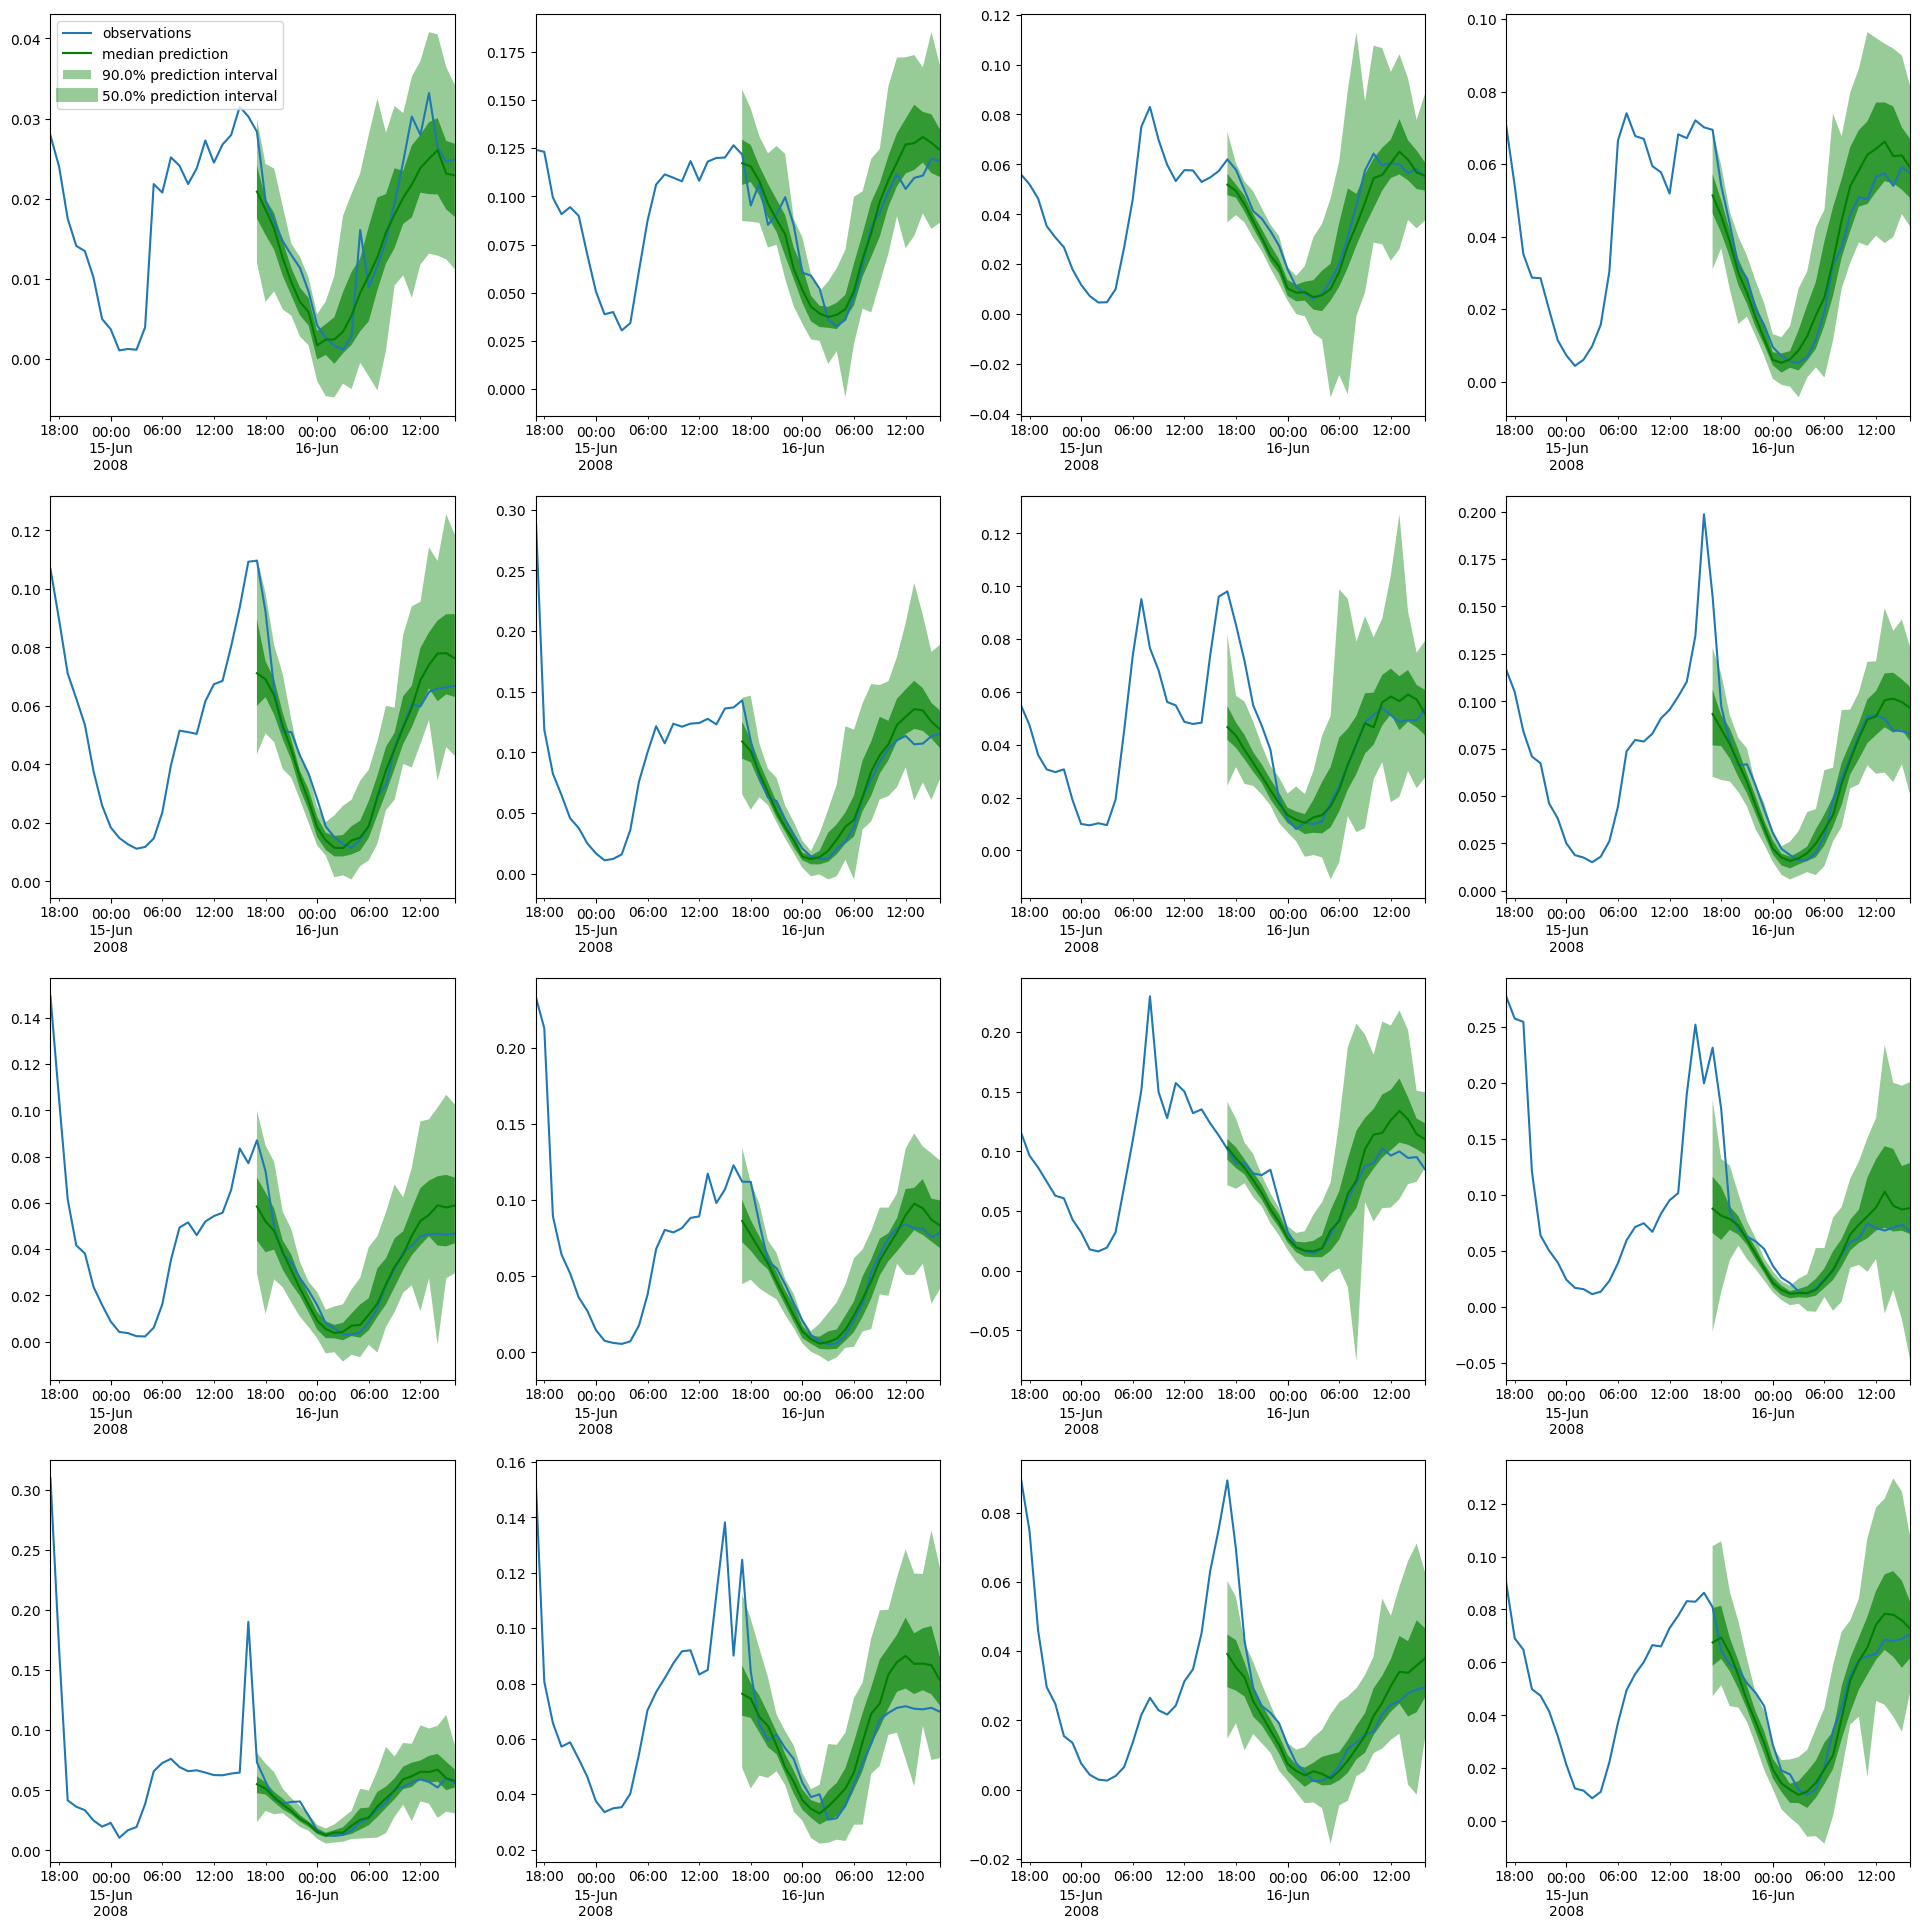

In [12]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()